# Assessment Task 1

## Set up environment

In [2]:
# Load required packages
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport

## Get data

In [3]:
# Import and inspect training data
df_train = pd.read_csv('../../data/raw/train.csv')
#display(df_train)

# Import and inspect test data
df_test = pd.read_csv('../../data/raw/test.csv')
#display(df_test)

## Data exploration

## Data manipulation

In [4]:
# Drop ID column - training data
df_train = df_train.drop(['Id_old','Id'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Save scaler into models folder
dump(scaler, '../../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=8)

In [5]:
# Drop ID column - test data
df_test = df_test.drop(['Id_old','Id'], axis=1)

# Standardize features - test data
X_test = scaler.fit_transform(df_test)

In [6]:
# Save split datasets into data folder
#np.save('../../data/processed/X_train', X_train)
#np.save('../../data/processed/X_val', X_val)
#np.save('../../data/processed/y_train', y_train)
#np.save('../../data/processed/y_val', y_val)
#np.save('../../data/processed/X_test', X_test)

## Set up experiment space

In [7]:
def plot_matrix_curve(reg):
    
    # Print confusion matrix to evaluate classification accuracy
    plot_confusion_matrix(reg, X_train, y_train, 
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true')
    plt.title("Confusion matrix - Training data")
    plt.show() 

    plot_confusion_matrix(reg, X_val, y_val,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true')
    plt.title("Confusion matrix - Validation data")
    plt.show() 
    
    # Calculate and plot ROC_AUC
    y_score = reg.predict_proba(X_val)[:,1]
    roc_auc_val = roc_auc_score(y_val, y_score)
    print("ROC_AUC:", roc_auc_val)
    reg_disp = plot_roc_curve(reg, X_val, y_val)
    
    #return reg_disp


## Experimentation

### Linear SVC

In [8]:
from sklearn.svm import SVC

linear_svc = SVC(kernel = 'linear', probability=True)

linear_svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [9]:
# Save fitted model into model folder
dump(linear_svc,  '../../models/David/linear_svc.joblib')

['../../models/David/linear_svc.joblib']

In [10]:
# Model predictions on training and validation data
y_train_pred = linear_svc.predict(X_train)
y_val_pred = linear_svc.predict(X_val)

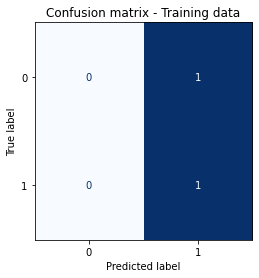

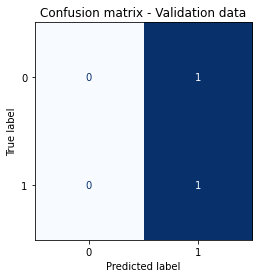

ROC_AUC: 0.5426030925594885


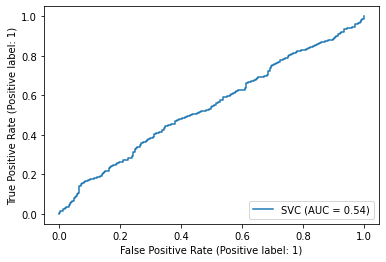

In [11]:
plot_matrix_curve(linear_svc)

### K Neighbours

In [66]:
# Create and fit classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [67]:
# Save fitted model into model folder
dump(neigh,  '../../models/David/neigh.joblib')

['../../models/David/neigh.joblib']

In [68]:
# Model predictions on training and validation data
y_train_pred = neigh.predict(X_train)
y_val_pred = neigh.predict(X_val)

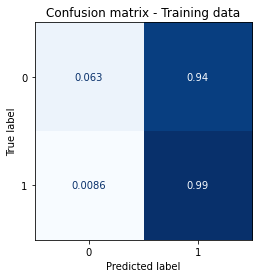

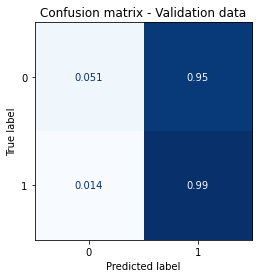

ROC_AUC: 0.6552088795918309


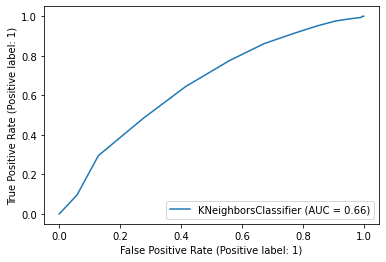

In [69]:
plot_matrix_curve(neigh)

### Logistic Regression - default

In [16]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Save fitted model into model folder
dump(log_reg,  '../../models/David/log_reg.joblib')

['../../models/David/log_reg.joblib']

In [18]:
# Model predictions on training and validation data
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

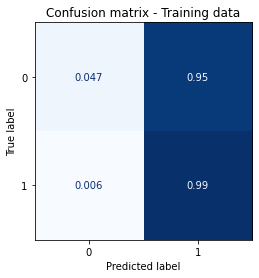

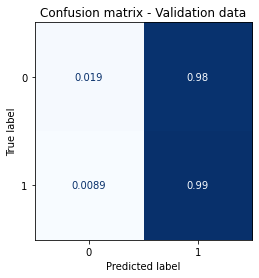

ROC_AUC: 0.7073251996952058


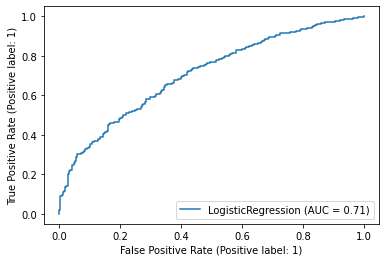

In [19]:
plot_matrix_curve(log_reg)

### Logistic Regression - ElasticNet

In [20]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression 

log_reg_elastic = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.5)

log_reg_elastic.fit(X_train, y_train)

c:\users\david anker\.virtualenvs\mdsi_adsi_feb21_at1-n_gyw-cp\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [21]:
# Save fitted model into model folder
dump(log_reg_elastic,  '../../models/David/log_reg_elastic.joblib')

['../../models/David/log_reg_elastic.joblib']

In [22]:
# Model predictions on training and validation data
y_train_pred = log_reg_elastic.predict(X_train)
y_val_pred = log_reg_elastic.predict(X_val)

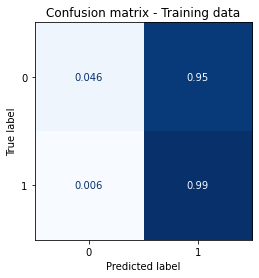

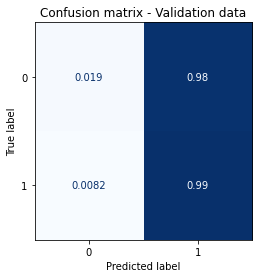

ROC_AUC: 0.7067486404501218


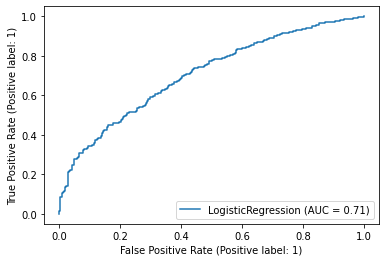

In [23]:
plot_matrix_curve(log_reg_elastic)

### Logistic Regression CV

In [24]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegressionCV 

C_list = np.linspace(0.001, 0.5, 20)

log_reg_cv = LogisticRegressionCV(
    Cs=C_list, 
    cv=20,
    penalty='l1',
    scoring='roc_auc', 
    solver='liblinear',
    tol=1e-4, 
    max_iter=1000, 
    class_weight='balanced', 
    n_jobs=10, #7
    verbose=2, 
    refit=True, 
    multi_class='ovr', 
    random_state=42)

log_reg_cv.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 out of  20 | elapsed:  1.1min remaining:   43.4s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.2min finished


[LibLinear]

LogisticRegressionCV(Cs=array([0.001     , 0.02726316, 0.05352632, 0.07978947, 0.10605263,
       0.13231579, 0.15857895, 0.18484211, 0.21110526, 0.23736842,
       0.26363158, 0.28989474, 0.31615789, 0.34242105, 0.36868421,
       0.39494737, 0.42121053, 0.44747368, 0.47373684, 0.5       ]),
                     class_weight='balanced', cv=20, max_iter=1000,
                     multi_class='ovr', n_jobs=10, penalty='l1',
                     random_state=42, scoring='roc_auc', solver='liblinear',
                     verbose=2)

In [25]:
# Save fitted model into model folder
dump(log_reg_cv,  '../../models/David/log_reg_cv.joblib')

['../../models/David/log_reg_cv.joblib']

In [26]:
# Model predictions on training and validation data
y_train_pred = log_reg_cv.predict(X_train)
y_val_pred = log_reg_cv.predict(X_val)

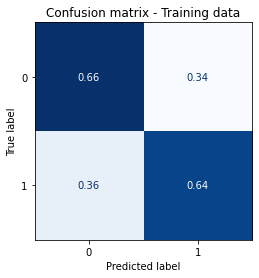

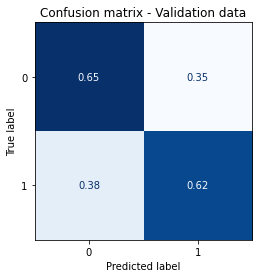

ROC_AUC: 0.7054303768495528


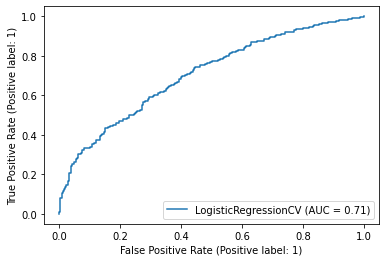

In [27]:
plot_matrix_curve(log_reg_cv)

### Random Forest - default

In [28]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
# Save fitted model into model folder
dump(random_forest,  '../../models/David/random_forest.joblib')

['../../models/David/random_forest.joblib']

In [30]:
# Model predictions on training and validation data
y_train_pred = random_forest.predict(X_train)
y_val_pred = random_forest.predict(X_val)

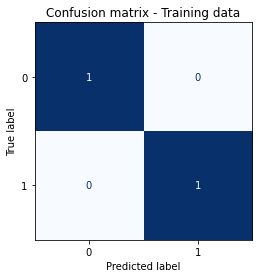

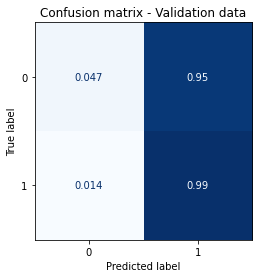

ROC_AUC: 0.6586841701168474


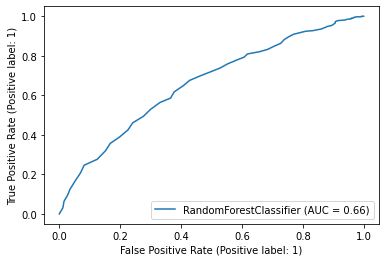

In [31]:
plot_matrix_curve(random_forest)

### Random Forest - second attempt

In [32]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier

random_forest2 = RandomForestClassifier(
    n_estimators=5, 
    criterion='entropy', 
    max_depth=15, 
    min_samples_split=3, 
    random_state=42, 
    verbose=1, 
    class_weight='balanced' 
)

random_forest2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=3, n_estimators=5,
                       random_state=42, verbose=1)

In [33]:
# Save fitted model into model folder
dump(random_forest2,  '../../models/David/random_forest2.joblib')

['../../models/David/random_forest2.joblib']

In [34]:
# Model predictions on training and validation data
y_train_pred = random_forest2.predict(X_train)
y_val_pred = random_forest2.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


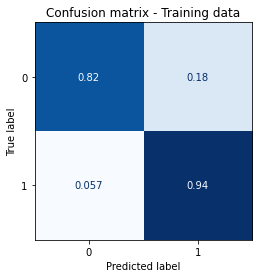

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


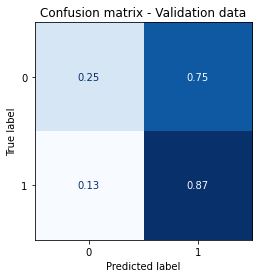

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


ROC_AUC: 0.6407282609640419


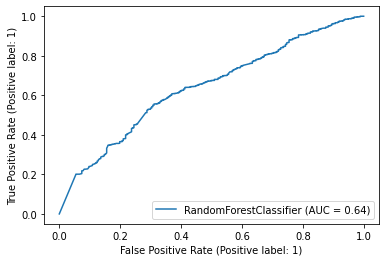

In [35]:
plot_matrix_curve(random_forest2)

### Support Vector Classification - default

In [36]:
# Create and fit classifier
from sklearn.svm import SVC

svm = SVC(kernel = 'sigmoid', probability=True)

svm.fit(X_train, y_train)

SVC(kernel='sigmoid', probability=True)

In [37]:
# Save fitted model into model folder
dump(svm,  '../../models/David/svm.joblib')

['../../models/David/svm.joblib']

In [38]:
# Model predictions on training and validation data
y_train_pred = svm.predict(X_train)
y_val_pred = svm.predict(X_val)

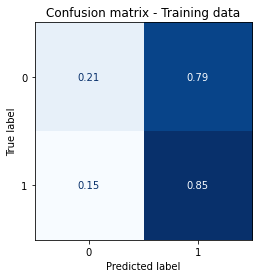

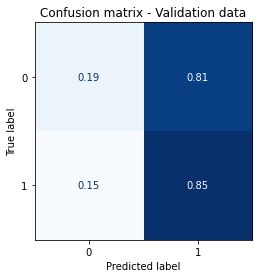

ROC_AUC: 0.5793116635907182


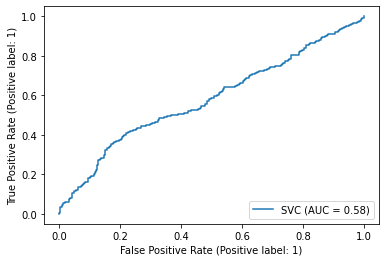

In [41]:
plot_matrix_curve(svm)

## Calculate and export test data predictions

In [73]:
# Predict target probabilities (use specific model name)
test_probs = random_forest2.predict_proba(X_test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [74]:
# Create dataframe object
test_probs_df = pd.DataFrame(test_probs, columns = ["TARGET_5Yrs"])

# Name 'ID' column
test_probs_df.index.name = "Id"

In [75]:
# Save output to csv
test_probs_df.to_csv("final2.csv")